# Дипломная работа: 
#### "Предсказание сонного/бодрого состояния водителя по его мозговым волнам".

Итак, у нас есть данные сигналов ЭЭГ от 4 водителей в разных состояниях: бодром и сонном. Эти данные содержат 10 признаков и столбец classification с предсказанием состояния водителя. 
Признаки: 
1. attention - показатель концентрации внимания (по стобальной шкале), meditation - показатель расслабления (по стобальной шкале). Эти 2 признака, по мнению авторов датасета, не являются надёжными, поскольку рассчитываются на основе самой гарнитуры.
2. 8 показателей мощности сигнала ЭЭГ на определённой частоте (измеряется в квадратном микровольте на герц (μV²/Гц)):
   delta - на частоте 1-4 Гц,          
   theta - на частоте 4-8 Гц,           
   lowAlpha - на частоте 8-10 Гц,      
   highAlpha - на частоте 10-12 Гц,     
   lowBeta - на частоте 12-15 Гц,    
   highBeta - на частоте 15-30 Гц,    
   lowGamma - на частоте 30-50 Гц,
   highGamma - на частоте 50-100 Гц.

#### Цель работы: 
 построить модель машинного обучения, которая бы по сигналам ЭЭГ предсказывала, находится ли водитель в сонном состоянии или бодром. Также мы посмотрим, какие сигналы ЭЭГ больше всего влияют на состояние бодрствования/сна

#### Подготовка и визуализация данных

In [533]:
import numpy as np
import pandas as pd

# библиотеки для визуализации
import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import shapiro, normaltest # тесты на нормальность распределения

In [534]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимыми
RANDOM_SEED = 100

# фиксируем версию пакетов, чтобы эксперименты были воспроизводимыми:
!pip freeze > requirements.txt

In [535]:
data = pd.read_csv('acquiredDataset.csv') # загружаем данные
print(data.shape)
data.head()

(3735, 11)


,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251,0
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825,0
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471,0


Посмотрим на структуру столбцов более внимательно:

In [536]:
# создаём пустой список
list_tuple = []
# пробегаемся по именам столбцов в таблице
for col in data.columns:
    # создаём кортеж
    item = (
        col, # имя столбца
        data[col].nunique(), # число уникальных значений
        data[col].dtypes, # тип столбца
        data[col].min(), # минимальное и максимальное значения
        data[col].max(), 
        data[col].isnull().sum(), # сколько пропусков
        data[data[col] == 0].shape[0], # сколько нулевых значений
        data[col].mean(), # среднее значение
        data[col].median() # медиана
    ) 
    # добавляем кортеж в список
    list_tuple.append(item) 
# создаём вспомогательную таблицу и сортируем её по количеству уникальных значений в столбце
structure = pd.DataFrame(
    list_tuple,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Min', 'Max', 'NaN', 'Zero', 'Mean', 'Median']
).sort_values(by='Num_Unique',  ignore_index=True)
structure

,Column_Name,Num_Unique,Type,Min,Max,NaN,Zero,Mean,Median
0,classification,2,int64,0,1,0,2135,0.428380,0.0
1,attention,60,int64,1,100,0,0,48.214726,48.0
2,meditation,60,int64,1,100,0,0,56.577510,56.0
3,lowGamma,3259,int64,6,289281,0,0,8117.130388,4440.0
4,highBeta,3494,int64,3,443589,0,0,23276.979384,9739.0
5,highAlpha,3561,int64,9,785947,0,0,30580.759036,14928.0
6,lowBeta,3573,int64,2,595549,0,0,25640.069076,13841.0
7,lowAlpha,3601,int64,32,699008,0,0,33413.343775,16481.0
8,highGamma,3651,int64,47,2328370,0,0,208725.809906,57198.0
9,theta,3680,int64,138,3194358,0,0,136242.001874,57972.0


In [537]:
data.duplicated().sum() # проверяем количество дубликатов в таблице

0

Итак, что мы увидели:

1) Все столбцы содержат численные значения (только столбец 'classification' является категориальным, но его мы кодировать не будем, поскольку он содержит категории, которые мы собираемся предсказывать, все остальные признаки являются непрерывными, их мы тоже не будем кодировать).

2) Пропущенных значений нет (также нет нулей, которыми исследователи могли бы заполнить пропущенные данные), поэтому нет необходимости избавляться от пропусков 

3) Классы (столбец 'classification') довольно сбалансированы (0.43% единиц и 0.57% нулей, разница не превышает 20%), поэтому дисбаланс выборки можно не учитывать

In [538]:
# создадим список признаков
col_list = list(data.columns) 
col_list.pop(-1) # убираем признак classification из списка
col_list

['attention',
 'meditation',
 'delta',
 'theta',
 'lowAlpha',
 'highAlpha',
 'lowBeta',
 'highBeta',
 'lowGamma',
 'highGamma']

Посмотрим на распределения признаков:

In [539]:
# создаём по таблице график, в котором каждому столбцу соответствует своя гистограмма (подграфик)
n_row = 5 # устанавливаем количество подграфиков в графике по вертикали
n_col = 2 # устанавливаем количество подграфиков в графике по горизонтали
fig = make_subplots(rows=n_row, cols=n_col, subplot_titles=col_list) 
ind = 0
for row in range(1, n_row+1):
    for col in range(1, n_col+1):
        fig.append_trace(go.Histogram(x=data[col_list[ind]]), row, col)
        fig.update_layout(height=800, width=1300)  # указываем высоту и ширину графика
        fig.update_layout(showlegend=False)  # скрываем легенду
        ind += 1

fig.show()

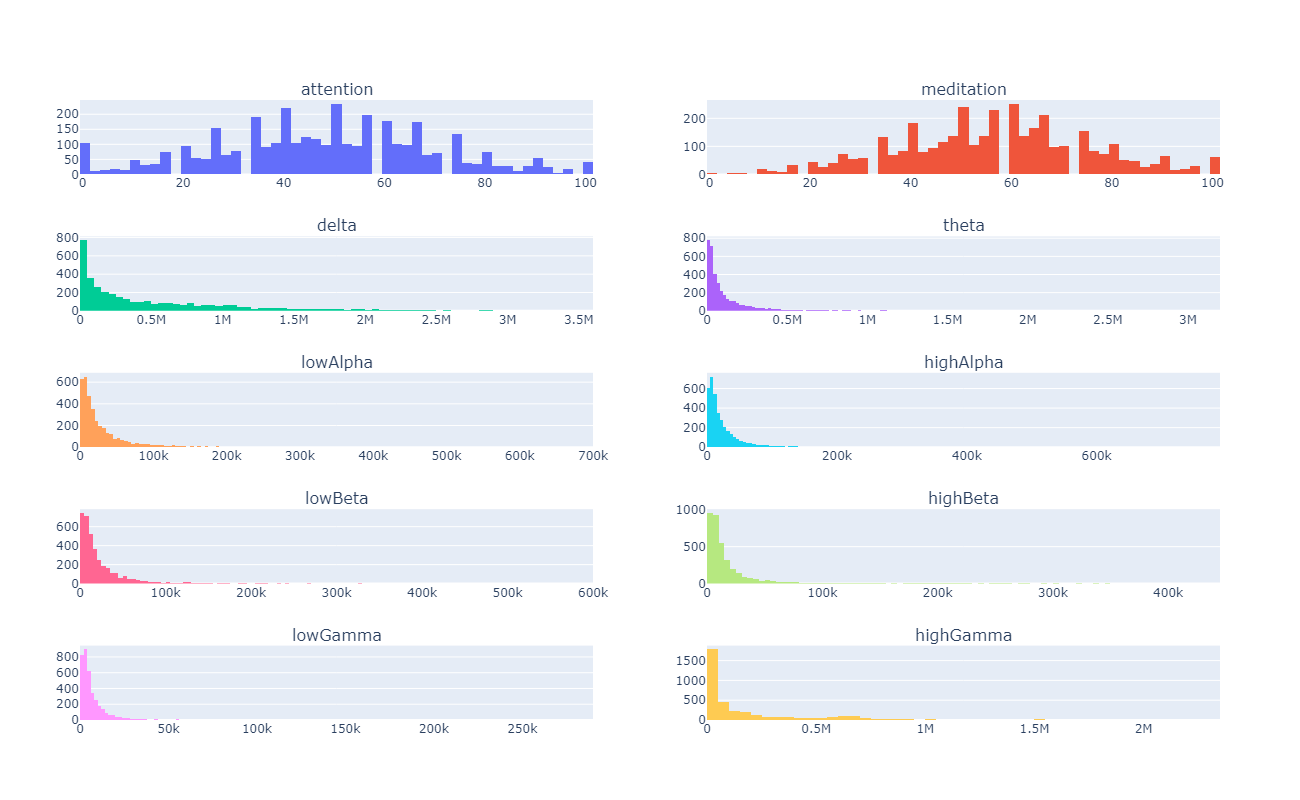

In [540]:
#(на случай, если изображение не отобразится)
from IPython.display import Image

# путь к изображению
image_path = 'plotly/1g-hi.png'
# отображение изображения
Image(filename=image_path)

Посмотрим, как соотносятся средние значения каждого признака для каждой категории столбца classification (0 и 1):

In [541]:
# создаём сводную таблицу со средними значениями
mean_table = data.groupby('classification')[col_list].mean().T 

# строим по этой таблице график
fig = px.bar(
    mean_table, 
    x=mean_table.columns, 
    y=mean_table.index, 
    title='Средние значения для каждой из категорий столбца classification', 
    barmode='group'
    )

fig.show()

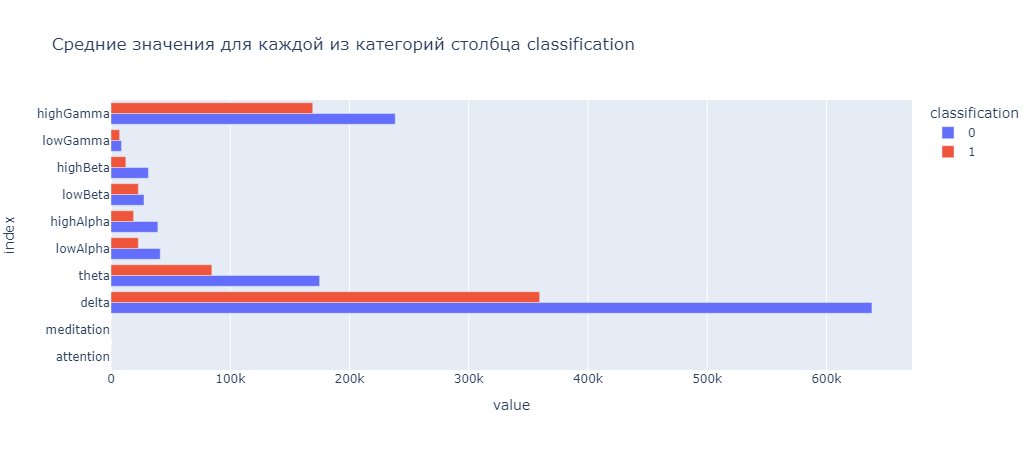

In [542]:
#(на случай, если изображение не отобразится)

# путь к изображению
image_path = 'plotly/2g-st.png'
# отображение изображения
Image(filename=image_path)

Если смотреть в целом, то можно увидеть преобладание категории 0 (кроме столбца attention) между средними значениями по каждому признаку (масштаб признаков meditation и attention на графике plotly можно подстроить, их средние значения около 50)

На всякий случай проверим, может ли распределение столбцов attention и meditation являться нормальным (остальные столбцы проверять не будем, поскольку по гистограммам видно кардинальное отличие от нормального распределения):

In [543]:
# формулируем гипотезы
H0 = 'данные распределены нормально'
Ha = 'данные не распределены нормально'

print('Проводим тест Шапиро-Уилка: ')
for col in ['attention', 'meditation']:
    if (shapiro(data[col])[1] >= 0.05) == True:
        print(f'В столбце {col} {H0}')
    else:
        print(f'В столбце {col} {Ha}')

print("\nПроводим тест Д'Агостино: ") 
for col in ['attention', 'meditation']:   
    if (normaltest(data[col])[1] >= 0.05) == True:
        print(f'В столбце {col} {H0}')
    else:
        print(f'В столбце {col} {Ha}')

Проводим тест Шапиро-Уилка: 
В столбце attention данные не распределены нормально
В столбце meditation данные не распределены нормально

Проводим тест Д'Агостино: 
В столбце attention данные не распределены нормально
В столбце meditation данные не распределены нормально


Построим коробчатые диаграммы:

In [544]:
# создаём по таблице график, аналогичный предыдущему
n_row = 10 # количество подграфиков по вертикали
n_col = 1 # количество подграфиков по вертикали

fig = make_subplots(rows=n_row, cols=n_col, subplot_titles=col_list) # создаёт фигуру из нескольких подграфиков
# (последний параметр настраивает название подграфика)

ind = 0 # номер элемента из списка со столбцами датафрейма (col_list)
# проходимся по каждому элементу каждой "строки" графика
for row in range(1, n_row+1): # проходимся по каждому элементу каждой "строки" графика
    for col in range(1, n_col+1):
        fig.append_trace(go.Box(x=data[col_list[ind]], name=''), row, col) # настраиваем каждый подграфик
        fig.update_layout(height=1300, width=1300)  # указываем высоту и ширину графика
        fig.update_layout(showlegend=False)  # скрываем легенду
        ind += 1

fig.show()

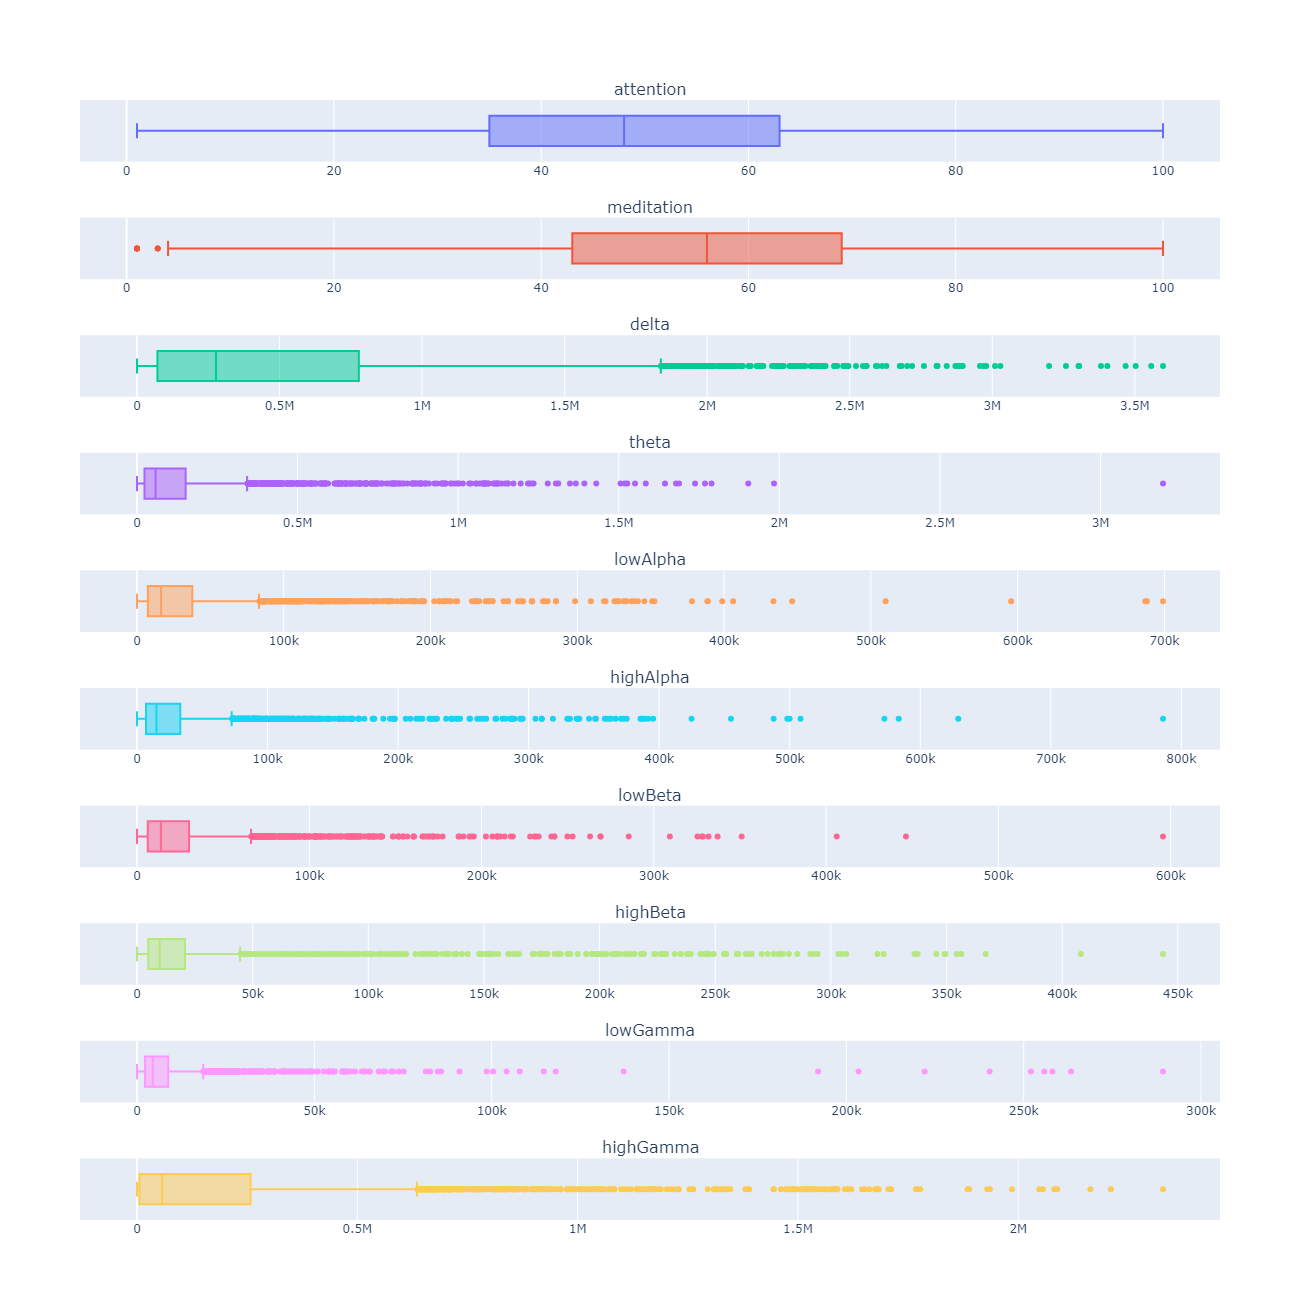

In [545]:
#(на случай, если изображение не отобразится)

# путь к изображению
image_path = 'plotly/3g-b.png'
# отображение изображения
Image(filename=image_path)

Поскольку мы видим, что в столбце meditation есть значения, которые могли бы быть выбросами (они выходят за границы (Q1 - 1,5IQR) или (Q3 + 1,5IQR)), то напишем функцию, которая бы удаляла эти записи из датафрейма.
(Остальные столбцы мы не трогаем, так как они по распределению слишком уж несимметричны, поэтому к ним применить данный метод не получится)

In [546]:
def outliers_iqr(df, feature):
    quartile_1, quartile_3 = df[feature].quantile(0.25), df[feature].quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return outliers, df

In [547]:
'''# применяем написанную функцию к столбцу 'meditation'
for col in ['meditation']:
    outliers, data = outliers_iqr(data, col)
    print(f'Число выбросов по методу Тьюки в столбце {col}: {outliers.shape[0]}')
print(f'Всего осталось {data.shape[0]} записей в таблице')'''

"# применяем написанную функцию к столбцу 'meditation'\nfor col in ['meditation']:\n    outliers, data = outliers_iqr(data, col)\n    print(f'Число выбросов по методу Тьюки в столбце {col}: {outliers.shape[0]}')\nprint(f'Всего осталось {data.shape[0]} записей в таблице')"

P.S. Однако данную функцию мы в итоге решили не применять (мы попробовали с этим признаком (очищенным и неочищенным) и без него, и результаты оказались лучше без него, к тому же авторы датасета посчитали этот признак ненадёжным), признак meditation из датасета удалим

#### Отбор признаков для будущей модели

Для начала посмотрим на связи между признаками:

In [548]:
data_corr = data.corr(method='spearman') # '''создаём матрицу корреляций (с коэффициентами корреляции 
# Спирмена, поскольку мы ищем зависимости между количественными данными, не распределёнными нормально, 
# и категориальным признаком)'''

x = list(data_corr.columns)
y = list(data_corr.index)
z = np.array(data_corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis',
    showscale=True
    )
fig.update_layout(height=1000, width=1000, showlegend=True)
#fig.update_layout(legend=dict(title=dict(text='Legend')))
fig.show()

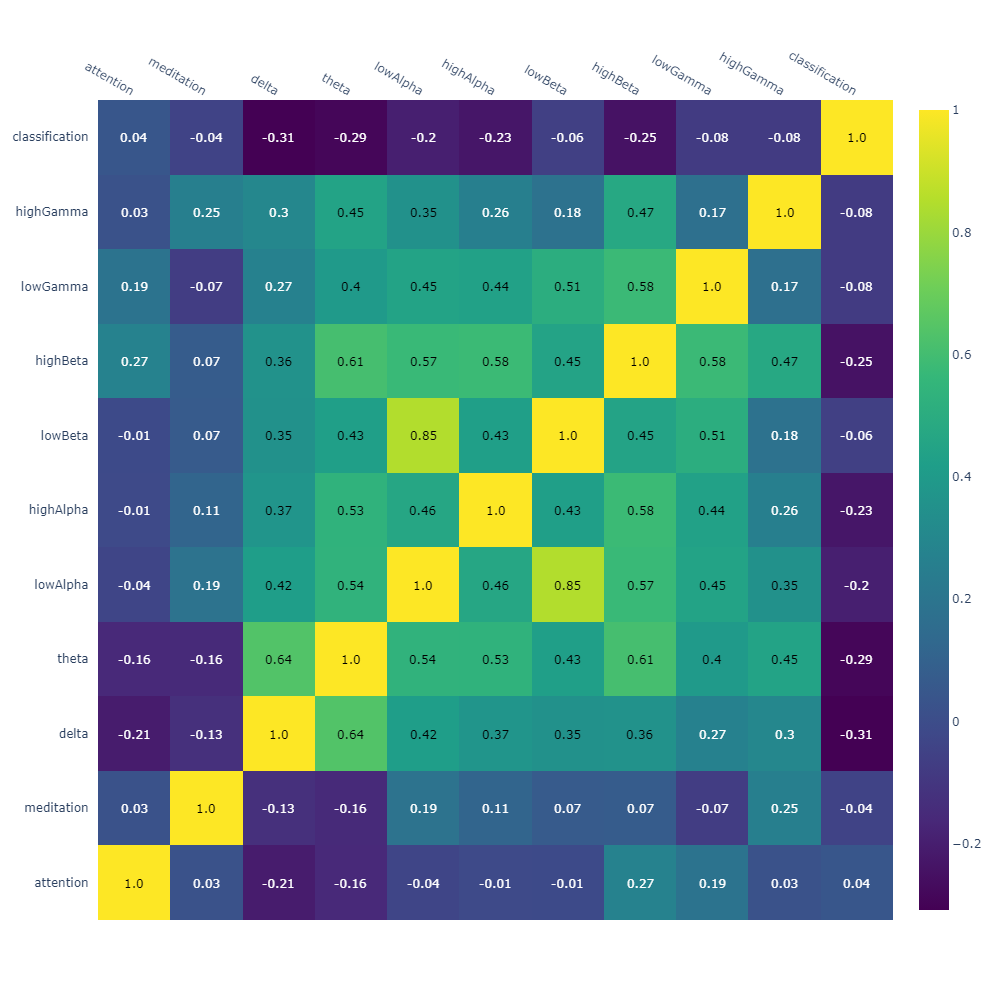

In [549]:
#(на случай, если изображение не отобразится)

from IPython.display import Image

# Путь к изображению
image_path = 'plotly/4d-mc.png'
# Отображение изображения
Image(filename=image_path)

Признаки lowAlpha и lowBeta мультиколлинеарные, поэтому мы удаляем один из них - тот, у которого коэффициент корреляции с признаком classification меньше (lowBeta)

In [550]:
data = data.drop('lowBeta', axis=1)

Тройка признаков, обладющих наиболельшей силой корреляции (соответствующей средней по силе связи): theta-delta (0.64), theta-highBeta (0.61) и highBeta-highAlfa (0.58). highBeta-lowAlpha (0.57). Признак classification, который мы собираемся предсказывать, имеет со всеми остальными очень слабую связь.

Признаки attention и meditation, исходя из описания авторов датасета, не являются надёжными, да они и не имеют хоть сколько-нибудь весомую связь с признаком classification, поэтому в дальнейшем анализе мы их использовать не будем 

In [551]:
data = data.drop(['attention', 'meditation'], axis=1)

Оставшиеся столбцы не требуют дополнительных преобразований (стандартизация/нормализация), поскольку они содержат похожие данные в идентичных единицах измерения (различные ритмы мозговой активности), поэтому этого этапа здесь не будет.

Теперь посмотрим, какие признаки наиболее важны для будущего предсказания. Для этого мы будем использовать два метода: 
1) метод с использованием случайного леса (Random Forest Importance),
2) метод с использованием SelectKBest.

In [552]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2,f_classif 

In [553]:
X = data.drop('classification', axis=1) # называем признаки для обучения X
Y = data['classification'] # называем столбец с категориями, которые мы будем предсказывать, Y

Воспользуемся первым методом:

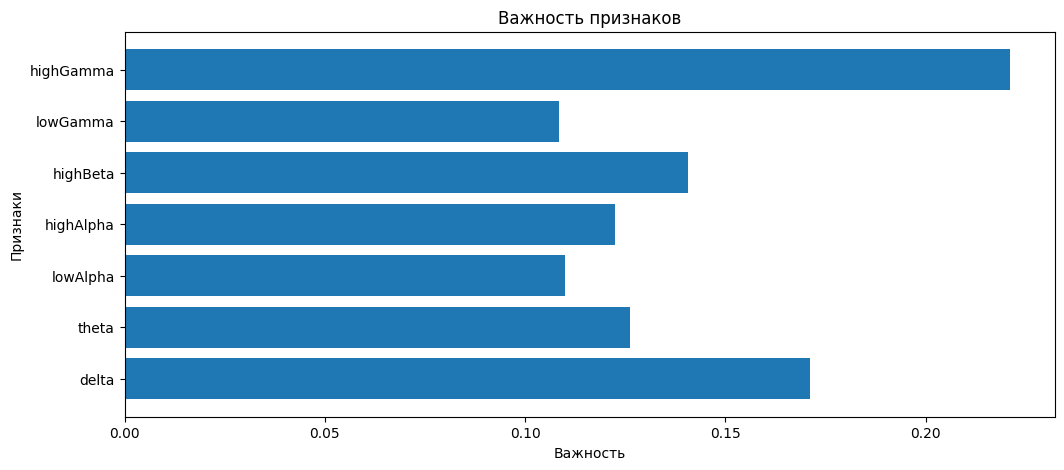

In [554]:
clf = RandomForestClassifier()
clf.fit(X, Y)

# построем диаграмму
plt.figure(figsize=(12,5))
plt.barh(X.columns, clf.feature_importances_)
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

Воспользуемся вторым методом:

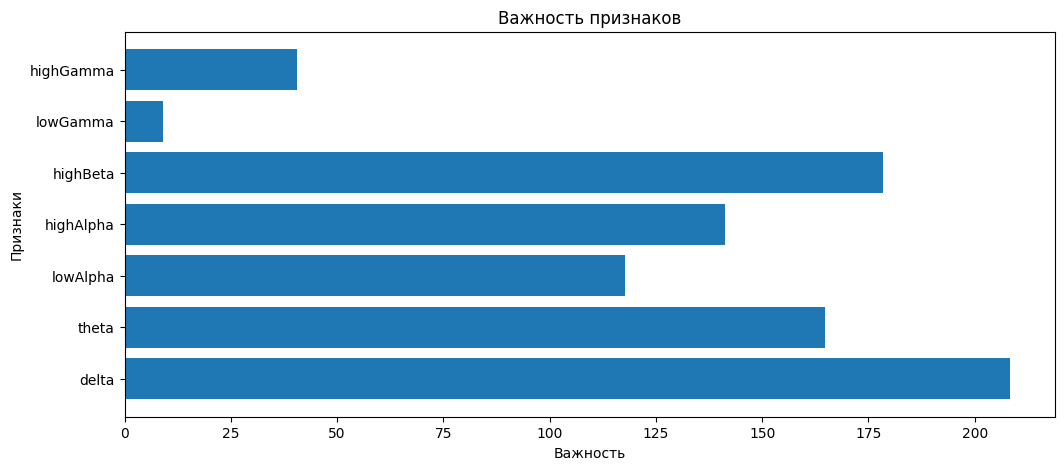

In [555]:
selector = SelectKBest(score_func=f_classif, k='all') # 'all' = выбрать все признаки
selector.fit(X, Y)

scores = selector.scores_ # оценки важности признаков

# создадим график важности признаков
plt.figure(figsize=(12,5))
plt.barh(X.columns, scores)
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

Можно сделать общий вывод, что в тройку самых важных признаков входят delta, highBeta и theta. Но от всех остальных признаков мы избавляться тоже не будем, поскольку у нас всего 7 признаков, что очень мало.

#### Подбор модели машинного обучения для задачи классификации

In [556]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [557]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [558]:
# создадим список моделей, а также возможные параметры, которые мы будем там менять
models = [
    {
    'name': 'Logistic Regression',
    'model': LogisticRegression(),
    'params': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'random_state' : [RANDOM_SEED]
        }
    },
    {
    'name': 'SGD',
    'model': SGDClassifier(),
    'params': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000, 3000],
        'random_state' : [RANDOM_SEED]
        }   
    },
    {
    'name': 'KNN',
    'model': KNeighborsClassifier(),
    'params': {'n_neighbors': [3, 5, 7]}
    },  
    {   
    'name': 'Decision Tree',
    'model': DecisionTreeClassifier(),
    'params': {
        'max_depth': [None, 1, 3, 5],
        'random_state' : [RANDOM_SEED]
        } 
    },
    {
    'name': 'Random Forest',
    'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [10, 50, 100], 
        'max_depth': [None, 5, 10], 
        'random_state' : [RANDOM_SEED]
        } 
    },  
    {
    'name': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
    'params': {
        'learning_rate': [0.1, 0.01, 0.001],
        'random_state' : [RANDOM_SEED]
        }  
    }
]

best_model = None
best_score = 0
best_params = 0

for model_data in models:
    model = model_data['model']
    params = model_data['params']
    
    grid = GridSearchCV(model, params, cv=5)
    grid.fit(X_train, y_train)
    print(f"Лучшая оценка для {model_data['name']} : {grid.best_score_} \n")
    model_best_params = grid.best_params_ 
    
    if grid.best_score_ > best_score:
        best_model = model_data['name']
        best_score = grid.best_score_
        best_params = model_best_params

# вывод наилучшей модели и ее оценки (accuracy)
print(f"Итоговая лучшая модель: {best_model}")
print(f"Лучшие параметры модели: {best_params}")
print(f"Итоговая лучшая оценка: {best_score}")

Лучшая оценка для Logistic Regression : 0.6170677567525988 

Лучшая оценка для SGD : 0.5447872940521454 

Лучшая оценка для KNN : 0.7188179014380637 

Лучшая оценка для Decision Tree : 0.7195871153014952 

Лучшая оценка для Random Forest : 0.7532581701501064 

Лучшая оценка для Gradient Boosting : 0.7471352277971912 

Итоговая лучшая модель: Random Forest
Лучшие параметры модели: {'max_depth': None, 'n_estimators': 100, 'random_state': 100}
Итоговая лучшая оценка: 0.7532581701501064


Выбираем модель с лучшими метриками - Random Forest.

#### Создание модели машинного обучения

In [559]:
rfc = RandomForestClassifier(max_depth=None, n_estimators=100, random_state=RANDOM_SEED)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'Точность предсказаний на тестовых данных: {metrics.accuracy_score(y_test, y_pred)}')

# посмотрим на матрицу ошибок
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# создадим график
fig = ff.create_annotated_heatmap(
    z=confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['True 0', 'True 1'],
    colorscale='Viridis',
    showscale=True
)
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)
fig.update_layout(height=500, width=700)  # указываем высоту и ширину графика

fig.show()

Точность предсказаний на тестовых данных: 0.7725245316681534


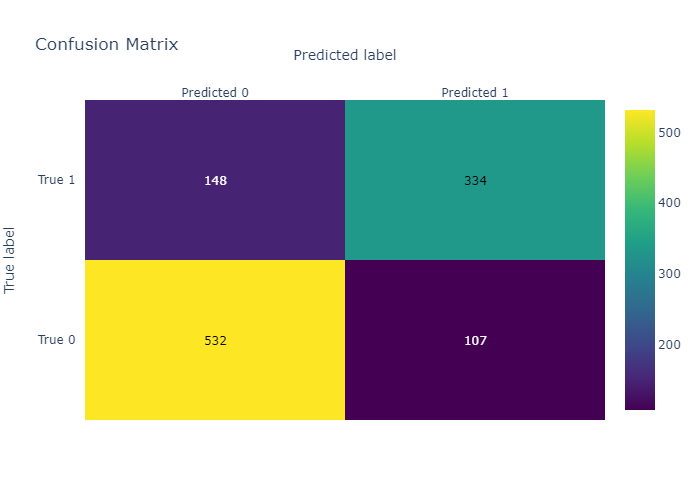

In [560]:
from IPython.display import Image

# путь к изображению
image_path = 'plotly/5g-cm.png'
# отображение изображения
Image(filename=image_path)

In [561]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       639
           1       0.76      0.69      0.72       482

    accuracy                           0.77      1121
   macro avg       0.77      0.76      0.77      1121
weighted avg       0.77      0.77      0.77      1121



#### Подготовка модели к продакшену

Для начала сохраним модель в файл в двоичном представлении:

In [562]:
import pickle

# производим сериализацию и записываем результат в файл формата pkl
with open('model_rfc.pkl', 'wb') as output:
    pickle.dump(rfc, output)

Теперь создадим Flask-приложение для предсказаний с использованием этой модели (опять же сохраненной в файле в двоичном формате):

In [563]:
from flask import Flask, request, jsonify
import pickle
import numpy as np

with open('model_rfc.pkl', 'rb') as input:
    model_pkl = pickle.load(input)

app = Flask(__name__)

n_features = 7

@app.route('/predict', methods=['POST'])
def predict():
    features = np.array(request.json)
    features = features.reshape(1, n_features) 
    prediction = model_pkl.predict(features)
    return  jsonify({'prediction': prediction[0]})

In [ ]:
if __name__ == '__main__':
    app.run('localhost', 5000)

#### Заключение
Мы создали ML-модель, которая предсказывает состояние водителя по сигналам ЭЭГ с точностью 0.77. Теперь достаточно подать в неё новые данные в формате JSON, чтобы получить предсказание